In [82]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from scipy.interpolate import interp1d
from skimage.draw import polygon
from PIL import Image, ImageOps

### 1. functions to create shapes

In [3]:
def create_circle(center=(100, 100), radius=40, size=(200, 200)):
    y, x = np.ogrid[:size[0], :size[1]]
    mask = (x - center[0])**2 + (y - center[1])**2 <= radius**2
    return mask.astype(np.uint8)

def create_square(top_left=(60, 60), length=80, size=(200, 200)):
    mask = np.zeros(size, dtype=np.uint8)
    mask[top_left[1]:top_left[1]+length, top_left[0]:top_left[0]+length] = 1
    return mask

def create_diamond(center=(100, 100), size=80, img_size=(200, 200)):
    y, x = np.ogrid[:img_size[0], :img_size[1]]
    mask = np.abs(x - center[0]) + np.abs(y - center[1]) <= size // 2
    return mask.astype(np.uint8)

def create_triangle(vertices=[(100, 60), (60, 140), (140, 140)], img_size=(200, 200)):
    rr, cc = polygon([v[1] for v in vertices], [v[0] for v in vertices], img_size)
    mask = np.zeros(img_size, dtype=np.uint8)
    mask[rr, cc] = 1
    return mask

def create_polygon(vertices, img_size=(200, 200)):
    from skimage.draw import polygon
    rr, cc = polygon([v[1] for v in vertices], [v[0] for v in vertices], img_size)
    mask = np.zeros(img_size, dtype=np.uint8)
    mask[rr, cc] = 1
    return mask

def create_star(n_points=5, r_outer=40, r_inner=20, center=(100, 100), img_size=(200, 200)):
    angles = np.linspace(0, 2*np.pi, n_points*2, endpoint=False)
    radii = np.array([r_outer if i % 2 == 0 else r_inner for i in range(len(angles))])
    x = center[0] + radii * np.cos(angles)
    y = center[1] + radii * np.sin(angles)
    return create_polygon(list(zip(x, y)), img_size)

### contour extraction

In [89]:
# def roll_contour_to_start_near(x, y, ref_point=(0, 0)):
#     coords = np.stack([x, y], axis=1)
#     dists = np.linalg.norm(coords - np.array(ref_point), axis=1)
#     start_idx = np.argmin(dists)
#     return np.roll(x, -start_idx), np.roll(y, -start_idx)

def is_clockwise(x, y):
    return np.sum((x[1:] - x[:-1]) * (y[1:] + y[:-1])) > 0

def enforce_counter_clockwise(x, y):
    if is_clockwise(x, y):
        return x[::-1], y[::-1]
    return x, y

def resample_contour(x, y, num_points=256):
    """Resample a contour to a fixed number of evenly spaced points."""

    # Compute cumulative arc length
    dx = np.diff(x)
    dy = np.diff(y)
    distances = np.sqrt(dx**2 + dy**2)
    cumulative = np.concatenate(([0], np.cumsum(distances)))
    total_length = cumulative[-1]

    # Create interpolation functions
    fx = interp1d(cumulative, x)
    fy = interp1d(cumulative, y)

    # Resample at evenly spaced distances
    new_distances = np.linspace(0, total_length, num_points)
    x_resampled = fx(new_distances)
    y_resampled = fy(new_distances)

    # Ensure the contour is counter-clockwise
    x_resampled, y_resampled = enforce_counter_clockwise(x_resampled, y_resampled)
    
    return x_resampled, y_resampled
  
def extract_contour(binary_mask, num_points=256):
    contours = measure.find_contours(binary_mask, 0.5)
    largest = max(contours, key=len)
    return resample_contour(largest[:, 1], largest[:, 0], num_points)

### fourier descriptors and reconstruction

In [49]:
def normalize_fd(Z):
    Z[0] = 0
    Z /= np.abs(Z[1])
    return Z
  
def compute_fd(x, y, normalize=True):
    z = x + 1j * y
    Z = np.fft.fft(z)
    return normalize_fd(Z) if normalize else Z
  
def low_pass(Z, num_points=256):
    Z_ = np.zeros_like(Z, dtype=complex)
    Z_[0] = Z[0]
    Z_[1:num_points//2] = Z[1:num_points//2]
    Z_[-num_points//2+1:] = Z[-num_points//2+1:]
    return Z_
  
def reconstruct_shape(Z):
    z = np.fft.ifft(Z)
    return z.real, z.imag

### interpolation methods

In [170]:
# Interpolation in real-imaginary space
def interpolate_fd_real_imag(fd_seq, t_vals, target_t):
    fd_array = np.array(fd_seq)
    interpolated = []
    for k in range(fd_array.shape[1]):
        real_interp = np.interp(target_t, t_vals, fd_array[:, k].real)
        imag_interp = np.interp(target_t, t_vals, fd_array[:, k].imag)
        interpolated.append(real_interp + 1j * imag_interp)
    return np.array(interpolated)
  
# Interpolation in magnitude-phase space
def interpolate_fd_magnitude_angle(fd_seq, t_vals, target_t):
    fd_array = np.array(fd_seq)  # shape: (T, N)
    interpolated = []

    for k in range(fd_array.shape[1]):
        mag = np.abs(fd_array[:, k])
        angle = np.angle(fd_array[:, k])

        def interp_angle(theta1, theta2, t):
            diff = ((theta2 - theta1 + np.pi) % (2 * np.pi)) - np.pi
            return theta1 + t * diff

        mag_interp = np.interp(target_t, t_vals, mag)
        angle_interp = interp_angle(angle[0], angle[1], (target_t - t_vals[0]) / (t_vals[1] - t_vals[0]))

        interpolated.append(mag_interp * np.exp(1j * angle_interp))

    return np.array(interpolated)

# Hybrid interpolation: real-imag for low freq, mag-angle for high freq
def interpolate_fd_hybrid(fd_seq, t_vals, target_t, split_k=10, low=True):
    fd_array = np.array(fd_seq)  # shape: (T, N)
    N = fd_array.shape[1]
    interpolated = []

    for k in range(N):
        if (low and k < split_k) or (not low and k >= split_k):
            # Real-imag interpolation
            real_interp = np.interp(target_t, t_vals, fd_array[:, k].real)
            imag_interp = np.interp(target_t, t_vals, fd_array[:, k].imag)
            interpolated.append(real_interp + 1j * imag_interp)
        else:
            # Magnitude-angle interpolation
            mag = np.abs(fd_array[:, k])
            angle = np.angle(fd_array[:, k])
            def interp_angle(theta1, theta2, t):
                diff = ((theta2 - theta1 + np.pi) % (2 * np.pi)) - np.pi
                return theta1 + t * diff
            mag_interp = np.interp(target_t, t_vals, mag)
            angle_interp = interp_angle(angle[0], angle[1], (target_t - t_vals[0]) / (t_vals[1] - t_vals[0]))
            interpolated.append(mag_interp * np.exp(1j * angle_interp))

    return np.array(interpolated)

# Linear interpolation directly between contours
def interpolate_contours_linear(contour1, contour2, t):
    x1, y1 = contour1
    x2, y2 = contour2
    x_interp = (1 - t) * x1 + t * x2
    y_interp = (1 - t) * y1 + t * y2
    return x_interp, y_interp

### testing w polygons

In [178]:
# given two binary masks, extract contours, interpolate between them, and visualize the results
def visualize_methods(shape1, shape2, num_params=256, num_steps=10):
  t_vals = np.array(np.linspace(0, 1, num_steps))
  
  x1, y1 = extract_contour(shape1)
  x2, y2 = extract_contour(shape2)
  P1 = compute_fd(x1, y1, normalize=True)
  P2 = compute_fd(x2, y2, normalize=True)
  resampled_contour1 = resample_contour(x1, y1, num_points=num_params)
  resampled_contour2 = resample_contour(x2, y2, num_points=num_params)
  sampled_P1 = low_pass(P1, num_params)
  sampled_P2 = low_pass(P2, num_params)
  
  interp_real_imag = [reconstruct_shape(interpolate_fd_real_imag([sampled_P1, sampled_P2], [0, 1], t)) for t in t_vals]
  interp_hybrid = [reconstruct_shape(interpolate_fd_hybrid([sampled_P1, sampled_P2], [0, 1], t, split_k=num_params//3)) for t in t_vals]
  interp_mag_angle = [reconstruct_shape(interpolate_fd_magnitude_angle([sampled_P1, sampled_P2], [0, 1], t)) for t in t_vals]
  interp_linear = [interpolate_contours_linear(resampled_contour1, resampled_contour2, t) for t in t_vals]
  
  fig, axs = plt.subplots(4, num_steps, figsize=(15, 10))
  
  for i, idx in enumerate(t_vals):
    x1, y1 = interp_real_imag[i]
    x2, y2 = interp_hybrid[i]
    x3, y3 = interp_mag_angle[i]
    x4, y4 = interp_linear[i]
    
    axs[0, i].plot(x1 - np.mean(x1), y1 - np.mean(y1))
    axs[0, i].set_title(f"Real-Imag t={t_vals[i]:.2f}")
    axs[0, i].invert_yaxis()
    axs[0, i].axis('equal')
    axs[0, i].axis('off')
    
    axs[1, i].plot(x2 - np.mean(x2), y2 - np.mean(y2))
    axs[1, i].set_title(f"Hybrid t={t_vals[i]:.2f}")
    axs[1, i].invert_yaxis()
    axs[1, i].axis('equal')
    axs[1, i].axis('off')
    
    axs[2, i].plot(x3 - np.mean(x3), y3 - np.mean(y3))
    axs[2, i].set_title(f"Mag-Angle t={t_vals[i]:.2f}")
    axs[2, i].invert_yaxis()
    axs[2, i].axis('equal')
    axs[2, i].axis('off')
    
    axs[3, i].plot(x4 - np.mean(x4), y4 - np.mean(y4))
    axs[3, i].set_title(f"Linear t={t_vals[i]:.2f}")
    axs[3, i].invert_yaxis()
    axs[3, i].axis('equal')
    axs[3, i].axis('off')
  
  plt.tight_layout()
  plt.show()

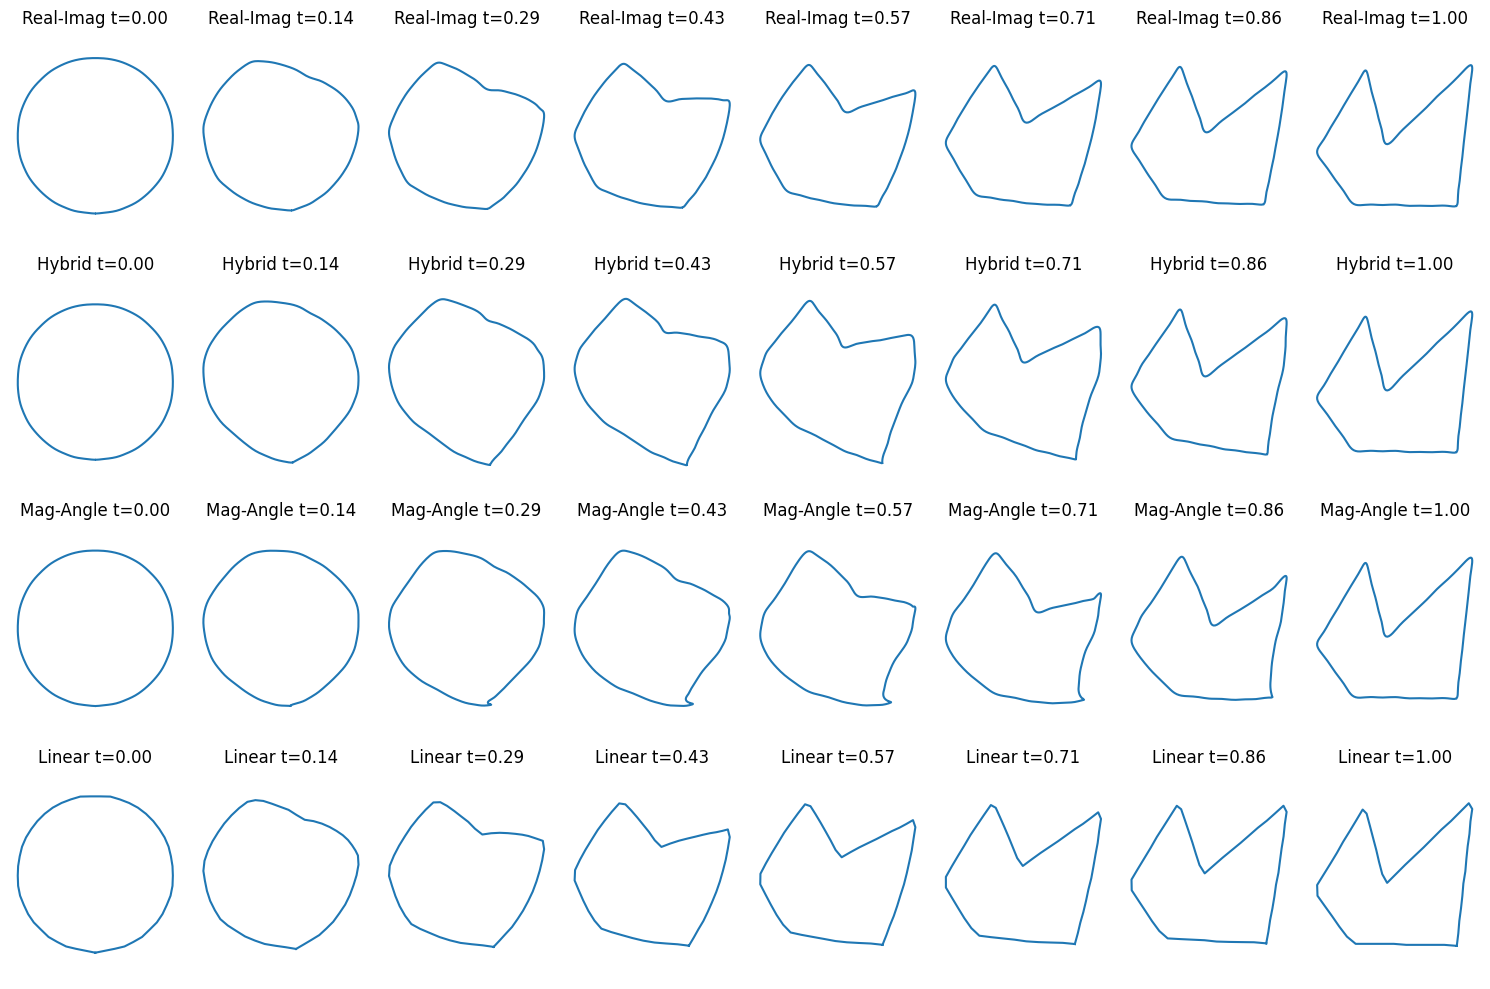

In [179]:
polygon1 = create_circle()
polygon2 = create_polygon(((75, 102), (55, 24), (5, 108), (42, 160), (146, 162), (162, 18)), img_size=(200, 200))

visualize_methods(polygon1, polygon2, num_params=50, num_steps=8)

### testing w animals

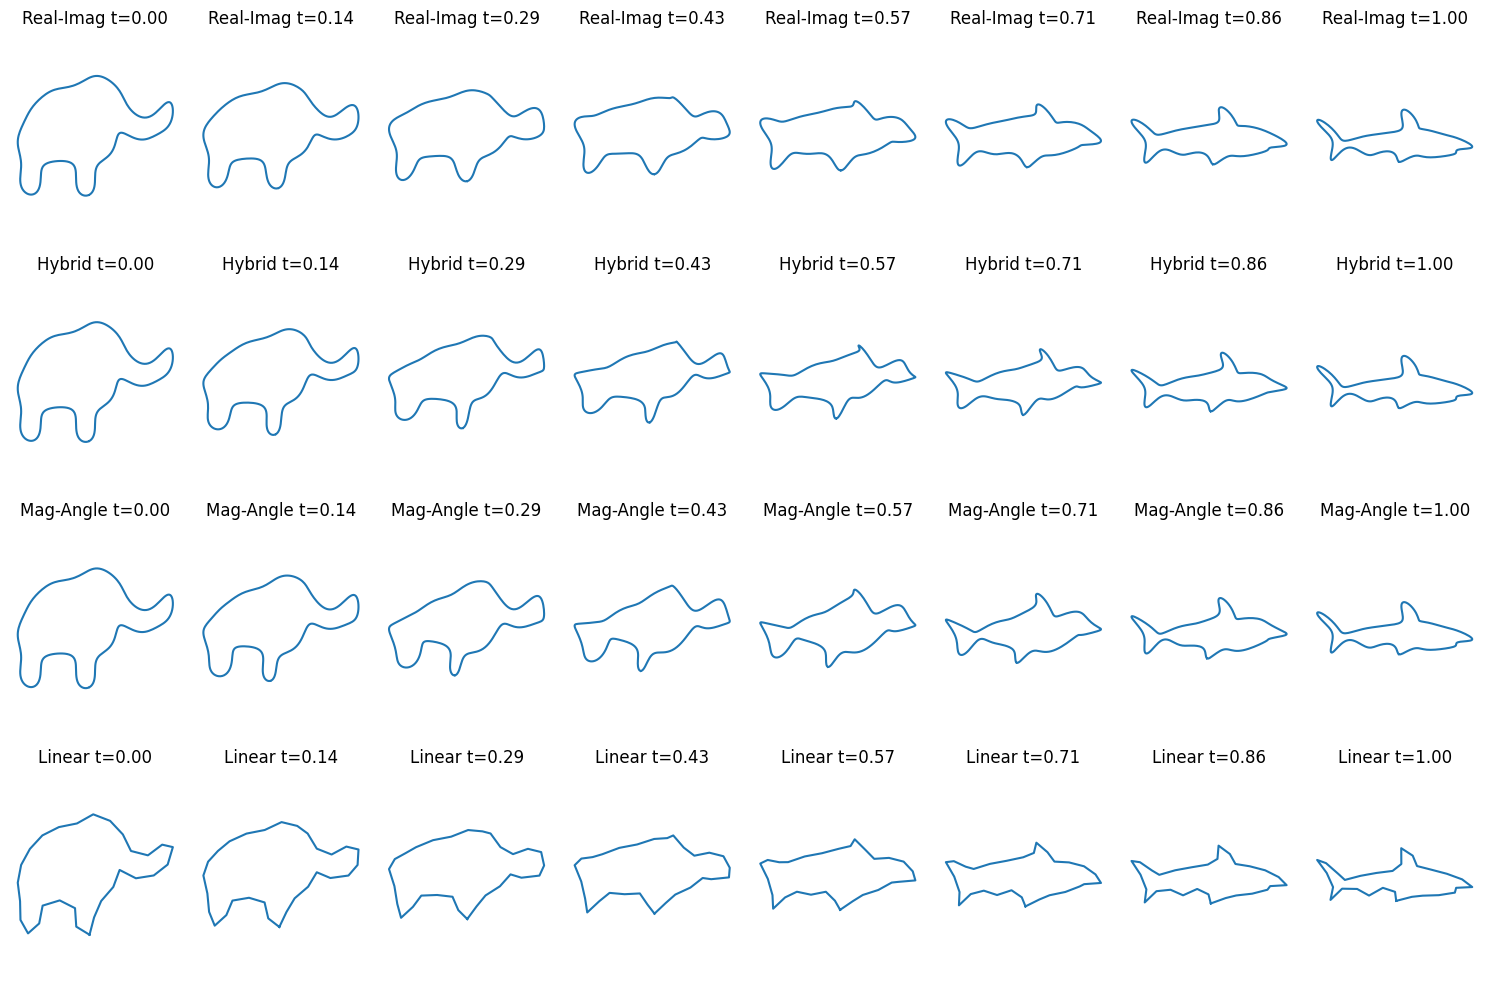

In [180]:
elephant = np.array(Image.open('images/elephant.png').convert('L'))
bin_elephant = (elephant > 200).astype(np.uint8) * 255
shark = np.array(ImageOps.mirror(Image.open('images/shark.png')).convert('L'))
bin_shark = (shark > 200).astype(np.uint8) * 255
visualize_methods(bin_elephant, bin_shark, num_params=30, num_steps=8)

### testing with SLC

In [197]:
# given two binary masks, extract contours, interpolate between them, and visualize the results
def validate_methods(struct, year1, year2, num_params=256, visualize=False):
  num_steps = year2 - year1 + 1
  years = np.arange(year1, year2 + 1)
  t_vals = np.array(np.linspace(0, 1, num_steps))
  
  assert len(years) == num_steps, "Number of years does not match number of steps."
  
  shape1 = np.load(f"{struct}/{struct}_mask_{year1}.npy")
  shape2 = np.load(f"{struct}/{struct}_mask_{year2}.npy")
  x1, y1 = extract_contour(shape1)
  x2, y2 = extract_contour(shape2)
  P1 = compute_fd(x1, y1, normalize=True)
  P2 = compute_fd(x2, y2, normalize=True)
  resampled_contour1 = resample_contour(x1, y1, num_points=num_params)
  resampled_contour2 = resample_contour(x2, y2, num_points=num_params)
  sampled_P1 = low_pass(P1, num_params)
  sampled_P2 = low_pass(P2, num_params)
  
  interp_real_imag = [reconstruct_shape(interpolate_fd_real_imag([sampled_P1, sampled_P2], [0, 1], t)) for t in t_vals]
  interp_hybrid = [reconstruct_shape(interpolate_fd_hybrid([sampled_P1, sampled_P2], [0, 1], t, split_k=num_params//3)) for t in t_vals]
  interp_mag_angle = [reconstruct_shape(interpolate_fd_magnitude_angle([sampled_P1, sampled_P2], [0, 1], t)) for t in t_vals]
  interp_linear = [interpolate_contours_linear(resampled_contour1, resampled_contour2, t) for t in t_vals]
  actual = [extract_contour(np.load(f"{struct}/{struct}_mask_{year}.npy")) for year in years]
  
  if visualize:
    fig, axs = plt.subplots(4, num_steps, figsize=(15, 10))
    
    for i, idx in enumerate(t_vals):
      x1, y1 = interp_real_imag[i]
      x2, y2 = interp_hybrid[i]
      x3, y3 = interp_mag_angle[i]
      x4, y4 = actual[i]
      
      axs[0, i].plot(x1 - np.mean(x1), y1 - np.mean(y1))
      axs[0, i].set_title(f"Real-Imag t={years[i]}")
      axs[0, i].invert_yaxis()
      axs[0, i].axis('equal')
      axs[0, i].axis('off')
      
      axs[1, i].plot(x2 - np.mean(x2), y2 - np.mean(y2))
      axs[1, i].set_title(f"Hybrid t={years[i]}")
      axs[1, i].invert_yaxis()
      axs[1, i].axis('equal')
      axs[1, i].axis('off')
      
      axs[2, i].plot(x3 - np.mean(x3), y3 - np.mean(y3))
      axs[2, i].set_title(f"Mag-Angle t={years[i]}")
      axs[2, i].invert_yaxis()
      axs[2, i].axis('equal')
      axs[2, i].axis('off')
      
      axs[3, i].plot(x4 - np.mean(x4), y4 - np.mean(y4))
      axs[3, i].set_title(f"Linear t={years[i]}")
      axs[3, i].invert_yaxis()
      axs[3, i].axis('equal')
      axs[3, i].axis('off')
    
    plt.tight_layout()
    plt.show()

  def contour_area(x, y):
    # using np.trap to get the area in the polygon
    return 0.5 * np.abs(np.dot(x, np.roll(y, -1)) - np.dot(y, np.roll(x, -1)))
  
  def scale_to_match_ends(y2, y1_start, y1_end):
    a = (y1_end - y1_start) / (y2[-1] - y2[0])
    b = y1_start - a * y2[0]
    return a * y2 + b
  
  # area comparison
  areas = np.array([contour_area(x, y) for x, y in actual])
  areas_interp_mag_angle = scale_to_match_ends(np.array([contour_area(x, y) for x, y in interp_mag_angle]), areas[0], areas[-1])
  areas_interp_real_imag = scale_to_match_ends(np.array([contour_area(x, y) for x, y in interp_real_imag]), areas[0], areas[-1])
  areas_interp_hybrid = scale_to_match_ends(np.array([contour_area(x, y) for x, y in interp_hybrid]), areas[0], areas[-1])
  areas_interp_linear = scale_to_match_ends(np.array([contour_area(x, y) for x, y in interp_linear]), areas[0], areas[-1])
  
  plt.figure(figsize=(10, 5))
  plt.plot(years, areas, label='Actual Area', marker='o')
  plt.plot(years, areas_interp_real_imag, label='Interpolated Real-Imag Area', marker='x')
  plt.plot(years, areas_interp_hybrid, label='Interpolated Hybrid Area', marker='x')
  plt.plot(years, areas_interp_mag_angle, label='Interpolated Mag-Angle Area', marker='x')
  plt.plot(years, areas_interp_linear, label='Interpolated Linear Area', marker='x')
  
  # plot linear from start to end
  plt.plot(years, np.linspace(areas[0], areas[-1], num_steps), label='Linear Trend', linestyle='--')
  
  plt.title(f"Area Comparison for {struct} from {year1} to {year2}")
  plt.xlabel("Year")
  plt.ylabel("Area")
  plt.legend()
  
  plt.show()

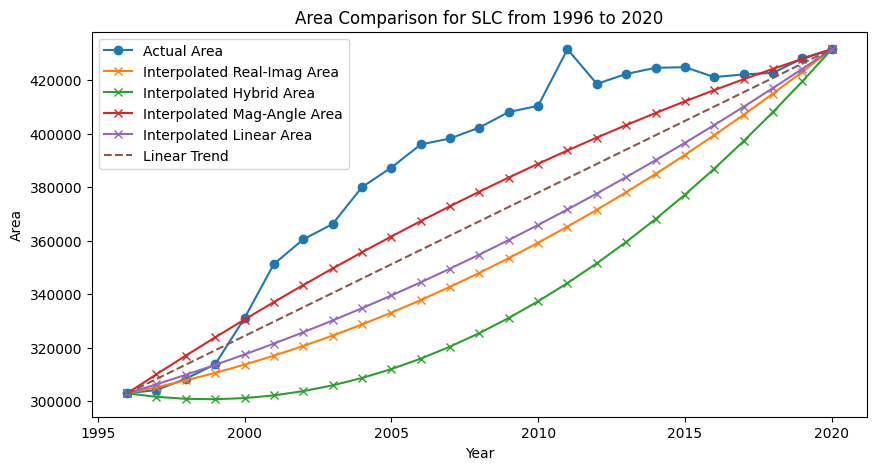

In [198]:
validate_methods("SLC", 1996, 2020, num_params=200, visualize=False)

### testing with mead

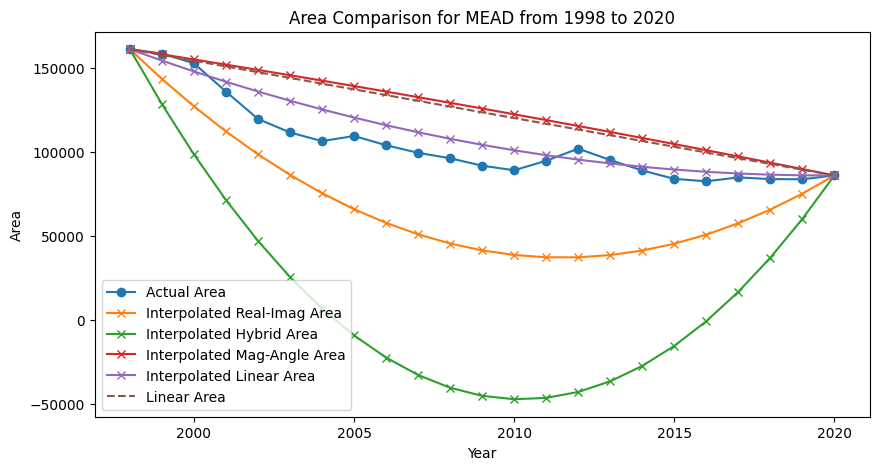

In [196]:
validate_methods("MEAD", 1998, 2020, num_params=200, visualize=False)